# Blood Pressure Estimation Using Machine Learning
Now that we have extracted the features from the signal, we apply machine learning to the data to obtain predicted Blood Pressure.


In [25]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os

## Reading the Extracted Data

`PPG-BP dataset.xlsx` consists of the patient data.
`features.csv` consists of the extracted PPG signal features.

In [2]:
data1 = pd.read_excel("PPG-BP dataset.xlsx")
data2 = pd.read_csv("features.csv").drop(labels=["Unnamed: 0"], axis=1)

In [3]:
data2.head()

,A0_2,A2_5,Ratio_A,fmax,mag_fmax,mean,median,st_dev,perc_25,perc_50,...,DyValleyTime,DDyValleyTime,b1_a1,b2_a2,ta1_tpp,ta2_tpp,tb1_tpp,tb2_tpp,ta12_tpp,tb12_tpp
0,0.138671,0.074447,1.862697,1.428571,0.112305,0.308536,0.249553,0.262066,0.103032,0.249553,...,-0.694331,-0.595283,-1.061773,-2.237499,-0.458834,-1.753006,-0.641998,-0.550416,1.294172,-0.091582
1,0.144504,0.089532,1.613985,0.952381,0.138408,0.366501,0.280489,0.303549,0.102355,0.280489,...,-1.382658,-0.999476,-0.291317,-1.446561,-0.897358,-1.786585,-1.404472,-1.015244,0.889228,-0.389228
2,0.156517,0.071385,2.192568,0.952381,0.154516,0.280349,0.187138,0.297964,0.042245,0.187138,...,-0.775369,-0.666317,-0.814766,-1.820737,-0.638857,-1.530286,-0.885714,-0.761143,0.891429,-0.124571
3,0.155914,0.069459,2.244676,0.952381,0.133627,0.301067,0.231981,0.286554,0.059443,0.231981,...,-0.870414,-0.755360,-0.823501,-1.884623,-0.776428,-1.665857,-1.057108,-0.917375,0.889429,-0.139733
4,0.154859,0.073679,2.101823,0.952381,0.145946,0.282091,0.155414,0.303519,0.060374,0.155414,...,-0.862411,-0.744354,-0.954021,-1.689448,-0.730140,-2.100467,-1.007009,-0.869159,1.370327,-0.137850


## RELIEFF model for Feature Selection

**Relieff** is an algorithm that takes a filter-method approach to feature selection that is notably sensitive to feature interactions.

Creating an empty DataFrame to store the selected variables for Systolic Blood Pressure.

In [4]:
data = pd.DataFrame() 

#### Adding Patient details as part of Relief

In [5]:
data["Age"] = data1["Age(year)"]
data["Heart rate"] = data1["Heart Rate(b/m)"]
data["Weight"] = data1["Weight(kg)"]
data["Height"] = data1["Height(cm)"]
data["BMI"] = data1["BMI(kg/m^2)"]

#### Adding extracted signal features to the dataframe

In [6]:
temp = ['mean',
       'median', 'st_dev', 'perc_25', 'perc_50', 'perc_75','b1_a1', 'b2_a2', 'ta1_tpp', 'ta2_tpp', 'tb1_tpp', 'tb2_tpp',
        'ta12_tpp', 'tb12_tpp']

data["A2_5"] = data2["A2_5"]
data["weight_tpp"] = data["Weight"]/data2["P2PTime"]
data["BMI_tpp"] = data["BMI"]/data2["P2PTime"]
data["weight_dytime"] = data["Weight"]/data2["DyPeakTime"]
data["weight_ValleyTime"] = data["Weight"]/data2["DyValleyTime"]

data["RMS"] = data2.RMS
data["shape_factor"] = data2.shape_factor

for i in temp:
    data[i] = data2[i]
    
data.head()

,Age,Heart rate,Weight,Height,BMI,A2_5,weight_tpp,BMI_tpp,weight_dytime,weight_ValleyTime,...,perc_50,perc_75,b1_a1,b2_a2,ta1_tpp,ta2_tpp,tb1_tpp,tb2_tpp,ta12_tpp,tb12_tpp
0,45,97,63,152,27.268006,0.074447,58.251619,25.212785,-126.955645,-90.734870,...,0.249553,0.446337,-1.061773,-2.237499,-0.458834,-1.753006,-0.641998,-0.550416,1.294172,-0.091582
1,50,76,50,157,20.284799,0.089532,50.788811,20.604816,-56.598177,-36.162222,...,0.280489,0.618680,-0.291317,-1.446561,-0.897358,-1.786585,-1.404472,-1.015244,0.889228,-0.389228
2,47,79,47,150,20.888889,0.071385,53.688707,23.861648,-84.038675,-60.616283,...,0.187138,0.411946,-0.814766,-1.820737,-0.638857,-1.530286,-0.885714,-0.761143,0.891429,-0.124571
3,45,87,65,172,21.971336,0.069459,78.941735,26.683929,-101.673001,-74.677066,...,0.231981,0.429615,-0.823501,-1.884623,-0.776428,-1.665857,-1.057108,-0.917375,0.889429,-0.139733
4,46,73,65,155,27.055151,0.073679,75.898420,31.591434,-103.950476,-75.370125,...,0.155414,0.425520,-0.954021,-1.689448,-0.730140,-2.100467,-1.007009,-0.869159,1.370327,-0.137850


#### Creating a Dataset for Diastolic blood pressure estimation

In [7]:
data_dia = data.drop(labels=["weight_dytime", "weight_ValleyTime", "A2_5"], axis=1)
data_dia["A0_2"] = data2.A0_2
data_dia.head()

,Age,Heart rate,Weight,Height,BMI,weight_tpp,BMI_tpp,RMS,shape_factor,mean,...,perc_75,b1_a1,b2_a2,ta1_tpp,ta2_tpp,tb1_tpp,tb2_tpp,ta12_tpp,tb12_tpp,A0_2
0,45,97,63,152,27.268006,58.251619,25.212785,0.404812,1.312041,0.308536,...,0.446337,-1.061773,-2.237499,-0.458834,-1.753006,-0.641998,-0.550416,1.294172,-0.091582,0.138671
1,50,76,50,157,20.284799,50.788811,20.604816,0.475884,1.298451,0.366501,...,0.618680,-0.291317,-1.446561,-0.897358,-1.786585,-1.404472,-1.015244,0.889228,-0.389228,0.144504
2,47,79,47,150,20.888889,53.688707,23.861648,0.409118,1.459320,0.280349,...,0.411946,-0.814766,-1.820737,-0.638857,-1.530286,-0.885714,-0.761143,0.891429,-0.124571,0.156517
3,45,87,65,172,21.971336,78.941735,26.683929,0.415638,1.380549,0.301067,...,0.429615,-0.823501,-1.884623,-0.776428,-1.665857,-1.057108,-0.917375,0.889429,-0.139733,0.155914
4,46,73,65,155,27.055151,75.898420,31.591434,0.414366,1.468907,0.282091,...,0.425520,-0.954021,-1.689448,-0.730140,-2.100467,-1.007009,-0.869159,1.370327,-0.137850,0.154859


Obtaining the target variables

In [8]:
Systolic = data1["Systolic Blood Pressure(mmHg)"]
Diastolic = data1["Diastolic Blood Pressure(mmHg)"]

## Machine Learning Models

Models used for:
> Systolic: RandomForestRegressor from Ensemble Trees

> Diastolic: Multi-Layer Perceptron from Neural Networks

### Training Model for Systolic Pressure

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

rgs = RandomForestRegressor(n_estimators=100)
rgs = rgs.fit(data, Systolic)
scores = np.sqrt(mean_squared_error(rgs.predict(data), Systolic))

### Training model for Diastolic Pressure

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

regs2 = MLPRegressor(random_state=1, max_iter=500).fit(data_dia, Diastolic)
scores2 = np.sqrt(mean_squared_error(regs2.predict(data_dia), Diastolic))

## Testing the models

Testing metric is chosen to be **Root Mean Squared Error**

In [11]:
print('RMSE for Systolic and Diastolic respectively is: ', scores, ", ", scores2)

RMSE for Systolic and Diastolic respectively is:  6.676477914248615 ,  11.042260625954153


### Testing the Systolic Prediction

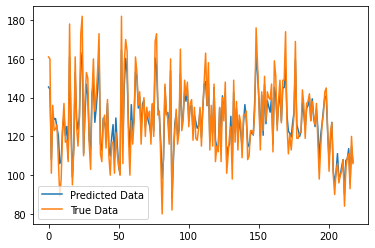

In [12]:
plt.plot(rgs.predict(data), label="Predicted Data");
plt.plot(Systolic, label="True Data");
plt.legend();

In [13]:
print("Prediction: ", rgs.predict(pd.DataFrame(data.iloc[217]).T)[0],
      "mmHg\n", "Truth: ", Systolic[217], "mmHg")

Prediction:  106.87 mmHg
 Truth:  106 mmHg


### Testing Diastolic Predictions

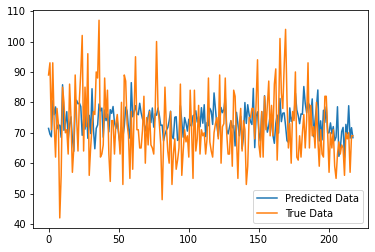

In [14]:
plt.plot(regs2.predict(data_dia), label="Predicted Data");
plt.plot(Diastolic, label="True Data");
plt.legend();

In [16]:
print("Prediction: ", regs2.predict(pd.DataFrame(data_dia.iloc[217]).T)[0],
      "mmHg\n", "Truth: ", Diastolic[217], "mmHg")

Prediction:  68.3850549789529 mmHg
 Truth:  69 mmHg


### Saving the model

Saving the models for systolic and diastolic pressure in `systolic_model.sav` and `diastolic_model.sav` respectively.

In [27]:
import pickle

systolic_path = os.getcwd() + "\\models\\systolic_model.sav"
diastolic_path = os.getcwd() + "\\models\\diastolic_model.sav"

pickle.dump(rgs, open(systolic_path, 'wb'))
pickle.dump(regs2, open(diastolic_path, 'wb'))

### Loading the Model

In [18]:
systolic_model = pickle.load(open(systolic_path, 'rb'))
diastolic_model = pickle.load(open(diastolic_path, 'rb'))

In [23]:
print("Systolic Prediction: ", round(systolic_model.predict(pd.DataFrame(data.iloc[217]).T)[0]),
      "mmHg\t", "Systolic Truth: ", Systolic[217], "mmHg")

print("Diastolic Prediction: ", round(diastolic_model.predict(pd.DataFrame(data_dia.iloc[217]).T)[0]),
      "mmHg\t", "Diastolic Truth: ", Diastolic[217], "mmHg")

Systolic Prediction:  107 mmHg	 Systolic Truth:  106 mmHg
Diastolic Prediction:  68 mmHg	 Diastolic Truth:  69 mmHg
